In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sts
from IPython.display import Image

In [4]:
from datetime import timedelta, datetime
import pickle
import json
import gc
from copy import copy, deepcopy
from collections import defaultdict, Counter
import requests

In [7]:
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)
    
with open('tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

### EDA

In [8]:
date_train_start = datetime.strptime('2019-01-01', '%Y-%m-%d')
date_val_start = datetime.strptime('2020-01-01', '%Y-%m-%d')


In [9]:
tournaments_train = []
tournaments_val = []

max_player_id = 0
max_team_id = 0

for key in tqdm(tournaments.keys(), position=0, leave=False):
    tournament_date = datetime.fromisoformat(tournaments[key]['dateStart']).replace(tzinfo=None)
    if tournament_date >= date_train_start:
        if not results[key]:
            continue

        total_questions = set()
        for team in results[key]:
            if team.get('mask') is not None:
                total_questions.add(len(team['mask']))

        if len(total_questions) > 1:
            continue
        tournament = dict()
        tournament['id'] = tournaments[key]['id']
        tournament['teams'] = []
        
        
        for team in results[key]:
            if team.get('mask') is None or team.get('mask').replace('1', '').replace('0', ''):
                continue
                
            if team['team']['id'] > max_team_id:
                max_team_id = team['team']['id']
            
            team_dict = dict()
            team_dict['id'] = team['team']['id']
            team_dict['mask'] = team['mask']
            team_dict['members'] = []
            
            for member in team['teamMembers']:
                
                player_id = member['player']['id']
                if player_id > max_player_id:
                    max_player_id = player_id
                    
                team_dict['members'].append(player_id)
                
            tournament['teams'].append(team_dict)
        
        if not tournament['teams']:
            continue
        if tournament_date < date_val_start:
            tournaments_train.append(tournament)
        else:
            tournaments_val.append(tournament)

In [10]:
with open('tournaments_train.json', 'w') as file:
    json.dump(tournaments_train, file)
    
with open('tournaments_val.json', 'w') as file:
    json.dump(tournaments_val, file)

In [12]:
with open('players.pkl', 'rb') as file:
    players = pickle.load(file)

In [21]:
members = defaultdict(set)
questions_counts = []
difficulty = []
questions_ratio = []
team_count_for_member = []


for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        questions_count = len(team_answers)
        correct_answers = sum(team_answers)
        tournament_answers.append(team_answers)
    

        
        for member in team['members']:
            members[member].add(tournament['id'])
    
    questions_counts.append(questions_count)  
    difficulty += (1 - np.array(tournament_answers).mean(axis=0)).tolist()
    questions_ratio += np.array(tournament_answers).mean(axis=0).tolist()
    
for member, teams in members.items():
    team_count_for_member.append(len(teams))


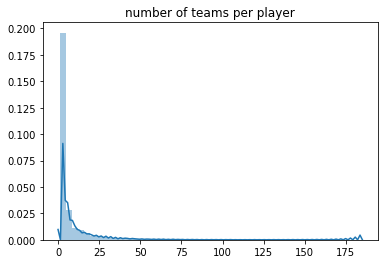

In [22]:
plt.title('number of teams per player')
sns.distplot(team_count_for_member)

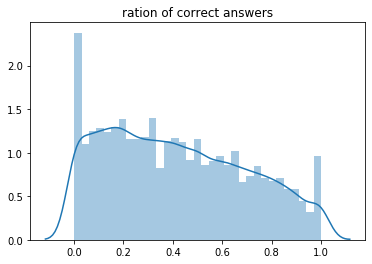

In [24]:
plt.title('ration of correct answers')
sns.distplot(questions_ratio)

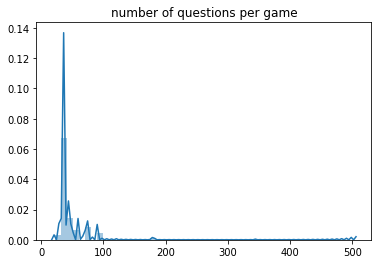

In [23]:
plt.title('number of questions per game')
sns.distplot(questions_counts)

In [25]:
members = set()
member_answers = defaultdict(int)
member_right_answers = defaultdict(int)
member_tours = defaultdict(int)

for tournament in tournaments_train:
    tournament_answers = []
    for team in tournament['teams']:
        for member in team['members']:
            member_answers[member] += len(team['mask'])
            member_right_answers[member] = sum(list(map(int, team['mask'])))
            member_tours[member] += 1
            members.add(member)
        

member_to_idx = {member: idx for idx, member in enumerate(members)}
idx_to_members = {idx: member for member, idx in member_to_idx.items()}

In [27]:
member_idxs = []
question_idxs = []
team_ids = []
tournament_ids = []
results = []
member_questions_count = []

questions_count = 0
for tournament in tournaments_train:
    tour_questions_count = len(tournament['teams'][0]['mask'])
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        for q in range(tour_questions_count):
            for member in team['members']:
                member_idxs.append(member_to_idx[member])
                question_idxs.append(len(member_to_idx) + questions_count + q)
                team_ids.append(team['id'])
                tournament_ids.append(tournament['id'])
                results.append(team_answers[q])
                member_questions_count.append(member_answers[member])
    questions_count += tour_questions_count
    

In [28]:
X = sparse.lil_matrix((len(member_idxs), len(member_to_idx) + questions_count),  dtype=int)
X[range(len(member_idxs)), member_idxs] = 1
X[range(len(member_idxs)), question_idxs] = 1
y = np.array(results)

Text(0.5, 1.0, 'Number of tournaments for players')

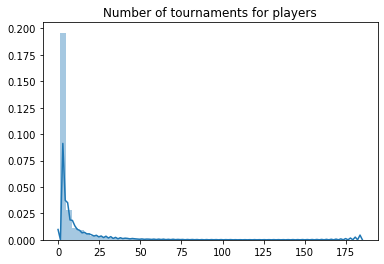

In [29]:
sns.distplot(list(member_tours.values()))
plt.title('Number of tournaments for players')

Text(0.5, 1.0, 'Number of questions for players')

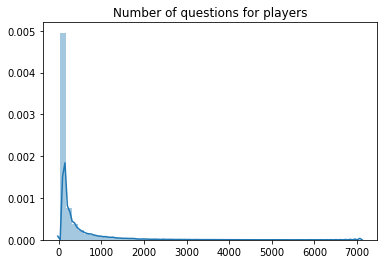

In [30]:
sns.distplot(list(member_answers.values()))
plt.title('Number of questions for players')

Text(0.5, 1.0, 'Number of correct questions for players')

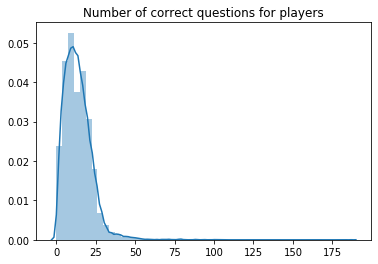

In [31]:
sns.distplot(list(member_right_answers.values()))
plt.title('Number of correct questions for players')

### Baseline

In [32]:
model = LogisticRegression()

In [34]:
model.fit(X, y)

/Users/aqice/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
def get_position(index):
    url = f'https://rating.chgk.info/api/players/{index}/rating/last'
    try:
        position = requests.get(url).json()['rating_position']
        position = int(position)
    except Exception as e:
        return np.nan
    
    return position

In [37]:
rating = model.coef_[0][:len(member_to_idx)]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)
    

#### Top 100 players

In [87]:
sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

rating_all = pd.DataFrame(sorted_rating)
rating_all['pred_pos'] = rating_all.index + 1
rating = rating_all.loc[:100]

In [88]:
rating['actual_position'] = rating['id'].apply(get_position)

/Users/aqice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
rating[rating['actual_position'] <= 100].dropna().shape

(55, 6)

Recall@100 for top is 55% players - not bad (without nans from api)

In [90]:
rating_boss = rating_all[rating_all['name'] == 'Сергей Николенко']
rating_boss['actual_position'] = rating_boss['id'].apply(get_position)
rating_boss

/Users/aqice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,score,id,name,questions_count,pred_pos,actual_position
9,3.538993,22799,Сергей Николенко,1806,10,10


bingo!

In [83]:
rating_boss['score'].values[0]

3.538993032677846

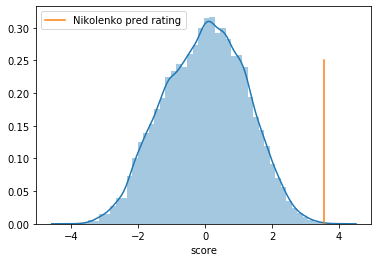

In [84]:
sns.distplot(rating_all['score'])
plt.plot([rating_boss['score'].values[0]] * 2, [0, 0.25], label='Nikolenko pred rating')
plt.legend()

### Predict new tournament on test

In [91]:
tournaments_test = []
tournaments_rating_true = []

for tournament in tournaments_val:
    teams_test = []
    teams_rating = []
    for team in tournament['teams']:
  
        memebers = [member for member in team['members'] if member in member_to_idx.keys()]
        team_test = copy(team)
        team_test['members'] = memebers
        
        if len(memebers) > 0:
            teams_test.append(team_test)
            team_answers = list(map(int, team['mask']))
            team_score = sum(team_answers)
            teams_rating.append(team_score)
     
    if len(teams_test) > 1:
        tournament_test = copy(tournament)
        tournament_test['teams'] = teams_test
        tournaments_test.append(tournament_test)
        tournaments_rating_true.append(teams_rating)

In [110]:
def predict_tournaments(model, tournaments, member_to_idx, matrix_dim_1):
    tournaments_rating_pred = []
    for tournament in tournaments:
        tournament_questions_count = len(tournament['teams'][0]['mask'])
        preds = []
        for team in tournament['teams']:
            member_idxs = [member_to_idx[member] for member in team['members']]
            members_count = len(member_idxs)
 
            X = sparse.lil_matrix((members_count, matrix_dim_1), dtype=int)
            X[range(len(member_idxs)), member_idxs] = 1
        
            fail_probas = model.predict_proba(X)[:, 0]
            team_proba = 1 - fail_probas.prod() 
            preds.append(team_proba)

        tournaments_rating_pred.append(preds)
    return tournaments_rating_pred

In [111]:
def get_correlations(tournaments_rating_true, tournaments_rating_pred):

    spearmanr_corrs = []
    kendall_corrs = []
    for i in range(len(tournaments_rating_true)):
        spearman = sts.spearmanr(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        kendall = sts.kendalltau(tournaments_rating_true[i], tournaments_rating_pred[i]).correlation
        spearmanr_corrs.append(spearman)
        kendall_corrs.append(kendall)

    return np.mean(spearmanr_corrs), np.mean(kendall_corrs)


In [112]:
tournaments_rating_pred = predict_tournaments(
    model=model, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
    matrix_dim_1=X.shape[1]
)

In [113]:
spearman, kendall = get_correlations(tournaments_rating_true, tournaments_rating_pred)

In [114]:
print('spearman corr', spearman)
print('kendall corr', kendall)

spearman corr 0.8026041850130352
kendall corr 0.644746457417624


In [124]:
class LogRegProb:
    def __init__(self, init_classifier=None):
        if init_classifier:
            self.w = np.hstack((init_classifier.intercept_, init_classifier.coef_[0]))
        else:
            self.w = None
        
    def fit(self, X, y, max_iters=1000, lr=10, batch_size=1000, tol=0.00001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')
        if self.w is None:
            self.w = np.random.normal(size=X.shape[1])
            
        losses = []
        prev_mean_loss = np.inf
        
        data_len = X.shape[0]
        
        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = sigmoid(X_batch.dot(self.w))
            losses.append(self.log_loss(y_batch, preds))
            if (i + 1) % 1000 == 0:
                new_mean_loss = np.mean(losses)
                if (prev_mean_loss - new_mean_loss) < tol:
                    break
                losses = []
                prev_mean_loss = new_mean_loss

            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
            self.w -= lr * grad 
    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = sigmoid(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))
    
    @staticmethod
    def log_loss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    


In [130]:
def get_calculated_label_prob(team_ids, question_idxs, preds):
    df_team = pd.DataFrame({'team': team_ids, 'question': question_idxs, 'fail_pred': preds[:, 0], 'success_pred': preds[:, 1]})
    df_team_pis = df_team.groupby(['team', 'question']).agg({'fail_pred': 'prod'}).reset_index()
    df_team_pis['team_success_pred'] = 1 - df_team_pis['fail_pred']
    df_team_pis.drop(columns=['fail_pred'], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', 'question'],  right_on=['team', 'question'])
    z = (df_team['success_pred'] / df_team['team_success_pred']).clip(0, 1)

    z[y == 0] = 0

    return z


In [131]:
spearman_corrs = []
kendall_corrs = []

model_prob = LogRegProb(init_classifier=model)

tournaments_rating_pred = predict_tournaments(
    model=model_prob, 
    tournaments=tournaments_test,
    member_to_idx=member_to_idx, 
    matrix_dim_1=X.shape[1]
)
spearman, kendall = get_correlations(tournaments_rating_true, tournaments_rating_pred)

spearman_corrs.append(spearman)
kendall_corrs.append(kendall)

n = 10

for i in range(n):

    # E-step
    preds = model_prob.predict_proba(X)

    label_probs = get_calculated_label_prob(team_ids, question_idxs, preds)
    
    
    # M-step
    model_prob.fit(X, label_probs)

    tournaments_rating_pred = predict_tournaments(
        model=model_prob, 
        tournaments=tournaments_test,
        member_to_idx=member_to_idx, 
        matrix_dim_1=X.shape[1]
    )
    
    spearman, kendall = get_correlations(tournaments_rating_true, tournaments_rating_pred)
    spearman_corrs.append(spearman)
    kendall_corrs.append(kendall)
    print(f'{i+1} out of {n}')

1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10
8 out of 10
9 out of 10
10 out of 10


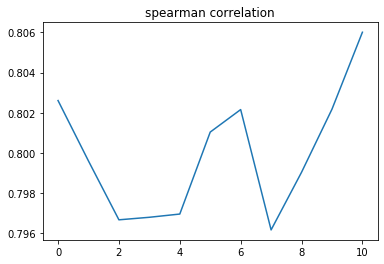

In [132]:
plt.title('spearman correlation')
plt.plot(spearman_corrs)

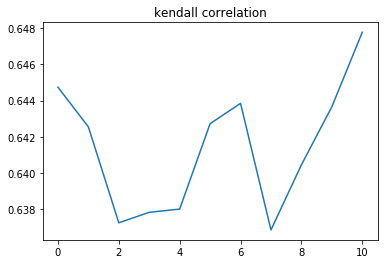

In [133]:
plt.title('kendall correlation')
plt.plot(kendall_corrs)

In [134]:
question_rating = model_prob.w[len(member_to_idx) + 1:]
rating = model_prob.w[1:len(member_to_idx) + 1]
rating_list = []
for idx, member in idx_to_members.items():
    item = {
        'score': rating[idx],
        'id': member,
        'name': players[member]['name'] + ' ' + players[member]['surname'],
        'questions_count': member_answers[member],
    }
    rating_list.append(item)

sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)

rating_all = pd.DataFrame(sorted_rating)
rating_all['pred_pos'] = rating_all.index + 1
rating = rating_all.loc[:100]

In [135]:
rating['actual_position'] = rating['id'].apply(get_position)

/Users/aqice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
rating[rating['actual_position'] <= 100].dropna().shape

(66, 6)

recall@100 for top is 66% ! Better results!

In [137]:
rating_boss = rating_all[rating_all['name'] == 'Сергей Николенко']
rating_boss['actual_position'] = rating_boss['id'].apply(get_position)
rating_boss

/Users/aqice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,score,id,name,questions_count,pred_pos,actual_position
30,4.586442,22799,Сергей Николенко,1806,31,10


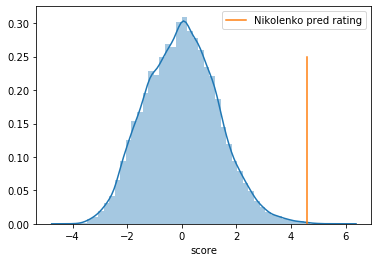

In [138]:
sns.distplot(rating_all['score'])
plt.plot([rating_boss['score'].values[0]] * 2, [0, 0.25], label='Nikolenko pred rating')
plt.legend()

### Tournaments based on difficulty

In [146]:
tournament_rating = dict()
question_to_tour = dict()

In [147]:
questions_count = 0
question_rating = model_prob.w[1 + len(member_to_idx):]
for tournament in tournaments_train:
    tour_questions_count = len(tournament['teams'][0]['mask'])
    start_index, end_index = questions_count, questions_count + tour_questions_count
    tournament_rating[tournament['id']] = np.mean(question_rating[start_index: end_index])
    
    for q in range(tour_questions_count):
        question_to_tour[questions_count + q] = {
            'tournament_id': tournament['id'],
            'tournament_name': tournaments[tournament['id']]['name'],
            'question_num': q + 1,
        }
    questions_count += tour_questions_count
    
tournament_rating = sorted(tournament_rating.items(), key=lambda x: x[1])
df_tournament_rating = pd.DataFrame(tournament_rating, columns=['id', 'rating'])
df_tournament_rating['name'] = df_tournament_rating['id'].apply(lambda x: tournaments[x]['name'])

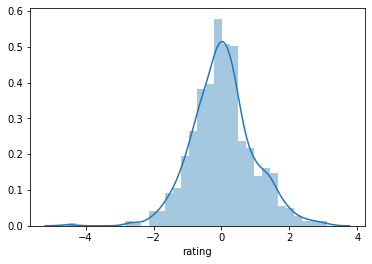

In [149]:
sns.distplot(df_tournament_rating['rating'])

In [151]:
df_tournament_rating.head(10)

,id,rating,name
0,6149,-4.511007,Чемпионат Санкт-Петербурга. Первая лига
1,5025,-2.655131,Кубок городов
2,5928,-2.625088,Угрюмый Ёрш
3,5159,-2.523994,Первенство правого полушария
4,6101,-2.115784,Воображаемый музей
5,5098,-2.056324,"Ра-II: синхрон ""Борского корабела"""
6,5741,-2.017835,All Cats Are Beautiful
7,5186,-2.011466,VERSUS: Коробейников vs. Матвеев
8,5587,-2.003211,Записки охотника
9,5083,-1.944208,Ускользающая сова


In [152]:
df_tournament_rating.tail(10)

,id,rating,name
594,5130,2.211052,Лига Сибири. VI тур.
595,5704,2.296670,(а)Синхрон-lite. Лига старта. Эпизод X
596,5012,2.303775,Школьный Синхрон-lite. Выпуск 2.5
597,5313,2.373549,(а)Синхрон-lite. Лига старта. Эпизод VI
598,5011,2.434734,(а)Синхрон-lite. Лига старта. Эпизод IV
599,5729,2.528464,Синхрон-lite. Выпуск XXX
600,5698,2.692943,(а)Синхрон-lite. Лига старта. Эпизод VII
601,5702,2.796130,(а)Синхрон-lite. Лига старта. Эпизод IX
602,5009,2.892319,(а)Синхрон-lite. Лига старта. Эпизод III
603,5013,3.096187,(а)Синхрон-lite. Лига старта. Эпизод V
